# 03a00 AtOnly Network-based feature selection

In [11]:
%matplotlib inline

import pandas as pd
import networkx as nx
import networkit as nk
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt

from collections import Counter

# pd.set_option('display.max_rows', None) 

# from IPython.core.interactiveshell import InteractiveShell
# InteractiveShell.ast_node_interactivity = "all"

from icecream import ic

# increase plot resolution
# import matplotlib as mpl
# mpl.rcParams['figure.dpi']= 150

In [12]:
# df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/BIO/LesionAtBcNormTPMReadsStarMapAtBc.csv")
df = pd.read_csv("../data/LesionAtBcNormTPMReadsStarMapAtBc.csv")

In [13]:
import os
import itertools
from scipy.spatial.distance import euclidean
import scipy.stats as stats
from scipy import io
import csv
import glob
import networkit as nk

In [24]:
def node_dimension(G,weight=None):
    node_dimension = {}
    for node in G.nodes():
        grow = []
        r_g = []
        num_g = []
        num_nodes = 0
        if weight == None:
            spl = nx.single_source_shortest_path_length(G,node)
        else:
            spl = nx.single_source_dijkstra_path_length(G,node)
        for s in spl.values():
            if s>0:
                grow.append(s)
        grow.sort()
        num = Counter(grow)
        for i,j in num.items():
            num_nodes += j
            if i>0:
                #if np.log(num_nodes) < 0.95*np.log(G.number_of_nodes()):
                r_g.append(i)
                num_g.append(num_nodes)
                if np.log(num_nodes) > 0.9*np.log(G.number_of_nodes()):
                    break
        x = np.log(r_g)
        y = np.log(num_g)
#         if len(r_g) < 3:
#             print("local",node)
        if len(r_g) > 1:
            try:
                slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
            except:
                print(node)
            node_dimension[node] = slope
        else:
            node_dimension[node] = 0
    return node_dimension

In [15]:
def FDC(G,weight=None):
    node_dimension = {}
    Gn = G.number_of_nodes()
    for node in G.nodes():
        grow = []
        r_g = []
        num_g = []
        num_nodes = 0
        deg = 0
        if weight == None:
            spl = nx.single_source_shortest_path_length(G,node)
        else:
            spl = nx.single_source_dijkstra_path_length(G,node)
        for s in spl.values():
            if s>0:
                grow.append(s)
        grow.sort()
        num = Counter(grow)
        deg = list(num.values())[0]
        for i,j in num.items():
            num_nodes += j
            if i>0:
                #if np.log(num_nodes) < 0.95*np.log(G.number_of_nodes()):
                r_g.append(i)
                num_g.append(num_nodes)
                if np.log(num_nodes) > 0.9*np.log(Gn):
                    break
        #if len(r_g) < 3:
            #print("local",node,len(r_g))
        if len(r_g) > 1:
            try:
                slope, intercept, r_value, p_value, std_err = stats.linregress(np.log(r_g), np.log(num_g))
            except:
                print(node)
            node_dimension[node] = slope/np.log(Gn/deg)
        else:
            node_dimension[node] = 0
    return node_dimension

## Network Approach

In [16]:
print("==== BotAt Data Summary ====")
print("HostGenoType:", set(df.loc[:,'HostGenoType']))
print("Bot Isolates: %d" % len(set(df.Isolate)))
print("Data samples: %d" % np.shape(df)[0])
print("Data features: %d" % np.shape(df)[1])

==== BotAt Data Summary ====
HostGenoType: {'npr1', 'col0', 'coi1'}
Bot Isolates: 96
Data samples: 1092
Data features: 29107


In [17]:
# extract feature names from RNASeq data
gene_names = list(df)[6:29107]
gene_names = [x.upper() for x in gene_names]

# Arabidopsis only feature gene set
At_list = gene_names[0:20340]
print("Number of At genes:", len(At_list))

Number of At genes: 20340


### Dataframe gene data decomposition according to organism

In [18]:
# data indices
At_idx_start = 6;
At_idx_end = 20346;
Bot_idx_start = 20346;
Bot_idx_end = 29107;

# gene lengths
At_length = At_idx_end - At_idx_start
Bot_length = Bot_idx_end - Bot_idx_start

### Total genes
# There are a total of 29101 Arabidopsis and Botrytis genes
df_AtBot = df.iloc[:, At_idx_start:Bot_idx_end]
# df_AtBot.head()

### Arabidopsis genes
# There are 20340 Arabidopsis genes
df_At = df.iloc[:, At_idx_start:At_idx_end]
# df_At.head()

### Botrytis genes
# There are 8761 Botrytis genes
df_Bot = df.iloc[:, Bot_idx_start:Bot_idx_end]
# df_Bot.head()

### Correlation matrix

In [19]:
# loading the .csv file as pandas dataframe
# df_load = pd.read_csv("./data/test_csv.csv", index_col=0)
# df_load.head()

# loading the .npy file as numpy array
file_npy = "../results/gene_correlation.npy"
AtBotCorrMatrix = np.load(file_npy)
print(np.shape(AtBotCorrMatrix))

(29101, 29101)


In [20]:
AtCorrMatrix = AtBotCorrMatrix[0:At_length,0:At_length]
# print(AtCorrMatrix[0:5,0:5])
print(np.shape(AtCorrMatrix))

# plt.imshow(AtCorrMatrix)
# plt.colorbar()

(20340, 20340)


### At Only Thresholding

In [21]:
h = 0.7
AdjMat = ((AtCorrMatrix > h) | (AtCorrMatrix < -h)) # * corrMatrix
# plt.imshow(AtBot_AdjMat)
# plt.colorbar()

Name: Graph with threshold 0.7
Type: Graph
Number of nodes: 20340
Number of edges: 347419
Average degree:  34.1612
Number of components:  12259
Number of 1-sized components: 12214
Largest component size: 7990
Component size counts:
[(1, 12214), (2, 29), (3, 6), (4, 4), (5, 2), (6, 1), (11, 1), (17, 1), (7990, 1)]

Name: Graph with threshold 0.7
Type: Graph
Number of nodes: 8126
Number of edges: 347419
Average degree:  85.5080


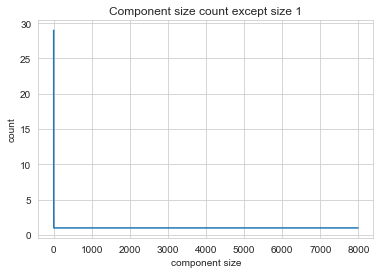

In [22]:
G = nx.from_numpy_array(AdjMat)
G.name = f"Graph with threshold {h}"

# remove self-loops
G.remove_edges_from(nx.selfloop_edges(G))
print(nx.info(G))

# check component size
# sorted list of connected components 
Gcc = sorted(nx.connected_components(G), key=len, reverse=True)

component_sizes = [len(cc) for cc in Gcc]
comp_ctr = Counter(component_sizes)
lists = sorted(comp_ctr.items())
x, y = zip(*lists[1:]) # unpack a list of pairs into two tuples
plt.plot(x,y)
plt.xlabel('component size')
plt.ylabel('count')
plt.title('Component size count except size 1')

print("Number of components: % d" % len(Gcc))
print("Number of 1-sized components: %d" % lists[0][1])
print("Largest component size: %d" % len(Gcc[0]))
print("Component size counts:")
print(lists)

# remove all single node components
node_set = set()
for G1 in Gcc:
    if len(G1)>1:
        node_set |= G1
        
node_list = np.array(list(node_set))
# node_list

# fdim
G_sub = G.subgraph(node_list)
print()
print(nx.info(G_sub))

#### Degree Centrality

In [13]:
# degree centrality
dc = nx.degree_centrality(G_sub)
nx.set_node_attributes(G_sub,dc,'degree')

dc_sort = {gene_names[k]: v for k, v in sorted(dc.items(), key=lambda item: item[1], reverse=True)}
# dc_sort = {k: v for k, v in sorted(dc.items(), key=lambda item: item[1], reverse=True)}
dc_sort2 = dict()
for (key, value) in dc_sort.items():
    if value > 0:
        dc_sort2[key] = value

dc_keys = list(dc_sort.keys())

file_out = f"../notebook/models/03a_features/AtOnly_degree_{h}.npy"
np.save(file_out, dc_keys, allow_pickle=True)

file_out = f"../notebook/models/03a_features/AtOnly_degree_{h}_dict.npy"
np.save(file_out, dc_sort, allow_pickle=True)

In [14]:
# # plot top 50 degree genes

# dc_keys = np.array(list(dc_sort.keys()))
# dc_vals = np.array(list(dc_sort.values()))
# # plt.barh([])

# for i in range(0,10):
#     print(i, dc_keys[i], dc_vals[i])
    
# cols = df.columns

# topN = 50
# dc_key50 = dc_keys[:topN]
# dc_val50 = dc_vals[:topN] 

# plt.figure(figsize=(8,16))
# plt.barh([cols[i] for i in np.flip(dc_key50[-50:])],np.flip(dc_val50[-50:]))
# plt.xlabel('Degree centrality')
# plt.ylabel('Genes')
# plt.title(f'AtBot Network Degree (h={h}) Feature Importance')

# file_out = f'../notebook/figures/03a_AtOnly/03a_AtOnly_degree_importances_{topN}.pdf'
# plt.savefig(file_out,bbox_inches='tight')

#### NFD

In [25]:
nfd = node_dimension(G_sub)

4.211977262102514
3.6442309049628445
3.821424497182757
3.165207909436423
5.550729266827894
3.3726310368813532
2.6189060391278622
4.079580864471846
3.211947196408192
4.797481338790323
2.884966959721746
1.543239436735828


KeyboardInterrupt: 

In [ ]:
nfd_sort = {gene_names[k]: v for k, v in sorted(nfd.items(), key=lambda item: item[1], reverse=True)}
nfd_sort2 = dict()
for (key, value) in nfd_sort.items():
    if value > 0:
        nfd_sort2[key] = value
        
nfd_keys = list(nfd_sort.keys())

# nfd_keys = np.array(list(nfd_sort.keys()))
# nfd_keys = nfd_keys + At_idx_start

file_out = f"../notebook/models/03a_features/AtOnly_nfd_{h}.npy"
np.save(file_out, nfd_keys, allow_pickle=True)

file_out = f"../notebook/models/03a_features/AtOnly_nfd_{h}_dict.npy"
np.save(file_out, nfd_sort, allow_pickle=True)
len(nfd_sort2)

#### FDC

In [ ]:
fdc = FDC(G_sub)

In [ ]:
fdc_sort = {gene_names[k]: v for k, v in sorted(fdc.items(), key=lambda item: item[1], reverse=True)}
fdc_sort2 = dict()
for (key, value) in fdc_sort.items():
    if value > 0:
        fdc_sort2[key] = value
        
fdc_keys = list(fdc_sort.keys())

file_out = f"../notebook/models/03a_features/AtOnly_fdc_{h}.npy"
np.save(file_out, fdc_keys, allow_pickle=True)

file_out = f"../notebook/models/03a_features/AtOnly_fdc_{h}_dict.npy"
np.save(file_out, fdc_sort, allow_pickle=True)
len(fdc_sort2)


#### Betweenness

In [ ]:
bc = nx.betweenness_centrality(G_sub)
nx.set_node_attributes(G_sub,bc,'betweenness')

bc_sort = {gene_names[k]: v for k, v in sorted(bc.items(), key=lambda item: item[1], reverse=True)}
bc_sort2 = dict()
for (key, value) in bc_sort.items():
    if value > 0:
        bc_sort2[key] = value

bc_keys = list(bc_sort.keys())
# bc_keys = np.array(list(bc_sort.keys())) + At_idx_start

file_out = f"../notebook/models/03a_features/AtOnly_betweenness_{h}.npy"
np.save(file_out, bc_keys, allow_pickle=True)

file_out = f"../notebook/models/03a_features/AtOnly_betweenness_{h}_dict.npy"
np.save(file_out, bc_sort, allow_pickle=True)